In [6]:
import simpy
import pandas as pd
import datetime
import holidays
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_pv = pd.read_csv('./data/PV_2024_normalized.csv', index_col=0)
df_H25 = pd.read_csv('./data/H25_BDEW.csv', index_col=0)

In [ ]:
def get_col(date):
    # if holiday or sunday return FT-{Month}
    if date in holidays.DE(subdiv='NW') or date.weekday() == 6:
        return "FT-" + date.strftime("%B")
    # if weekday return WT-{Month}
    if date.weekday() < 5:
        return "WT-" + date.strftime("%B")
    # default is saturday return SA-{Month}
    return "SA-" + date.strftime("%B")

# BDEW Dynamisierungsfunktion
def dynamisierungsfunktion(x0: float, t: float) -> float:
    """
    Parameters
    ----------
    x0 : float
        Quarter-hour value from the profile table.
    t : float
        Day of the year (1–365, or 1–366 for leap years).

    Returns
    -------
    float
        Resulting quarter-hour value x.
    """
    factor = (
        -3.92e-10 * t**4
        + 3.20e-7  * t**3
        - 7.02e-5  * t**2
        + 2.10e-3  * t
        + 1.24
    )
    return x0 * factor

class SolarPanel:
    def __init__(self, env, start_date, profile, kWp):
        self.env = env
        self.output = 0
        self.kWp = kWp
        self.profile = profile
        self.start_date = start_date
        self.efficency = 1
        # solar panels ~0.3%(0.003) - 0.8%(0.008) efficency loss per year
        self.loss = 0.005 
        self.process = env.process(self.run())

    def run(self):
        while True:
            quaterhour = int(self.env.now % 96)
            self.efficency = self.efficency - self.efficency * (self.loss/(96*365))
            current_date = self.start_date + datetime.timedelta(days=int(self.env.now / 96))
            col_key = str(current_date.replace(year=2024))   # if your columns are all 2024 dates
            sun_efficency  = self.profile[col_key].iloc[quaterhour]
            self.output = self.kWp * 0.25 * sun_efficency * self.efficency
            yield self.env.timeout(1)

class Battery:
    def __init__(self, env, capacity_kWh):
        self.env = env
        self.capacity = capacity_kWh
        self.efficency = 1
        # batteries ~1%(0.01) - 4%(0.04) efficency loss per year
        self.loss = 0.03
        self.level = 0
        self.history = []
        self.process = env.process(self.run())

    def charge(self, amount):
        available_space = self.capacity * self.efficency - self.level
        actual = min(amount, available_space)
        self.level += actual
        return amount - actual  # Return unused energy

    def discharge(self, amount):
        actual = min(self.level, amount)
        self.level -= actual
        return actual
    
    def run(self):
        while True:
            self.efficency = self.efficency - self.efficency * (self.loss/(96*365))
            self.history.append(self.level)
            yield self.env.timeout(1)

class Household:
    def __init__(self, env, solar, battery, stats, start_date, consumption_profile, yearly_consumption_kWh, initial_cost):
        self.env = env
        self.solar = solar
        self.battery = battery
        self.stats = stats
        self.start_date = start_date
        self.initial_cost = initial_cost
        self.consumption_profile = consumption_profile/1_000_000*yearly_consumption_kWh
        self.process = env.process(self.run())

    def run(self):
        while True:
            quarter_hour = int(self.env.now % 96)

            currentDate = self.start_date + datetime.timedelta(days=int(self.env.now / 96))
            demand0 = self.consumption_profile[get_col(currentDate)].iloc[quarter_hour]
            demand = dynamisierungsfunktion(demand0, currentDate.timetuple().tm_yday)
            production = self.solar.output

            # print(f"[Date {currentDate}] Demand0: {demand0:.2f}, Demand: {demand:.2f}, Solar: {production:.2f}, Battery: {self.battery.level:.2f}")
            if math.isnan(self.battery.level):
                return

            # Step 0: add demand to electricity used
            self.stats['electricity_used'] += demand
            
            # Step 1: Meet demand from solar
            from_solar = min(demand, production)
            remaining_demand = demand - from_solar
            surplus = production - from_solar
            self.stats['solar_used'] += from_solar

            # Step 2: Try to meet remaining demand from battery
            from_battery = self.battery.discharge(remaining_demand)
            self.stats['battery_used'] += from_battery
            remaining_demand -= from_battery

            # Step 3: Get any remaining demand from grid
            from_grid = remaining_demand
            self.stats['grid_used'] += from_grid
            
            # Step 4: Store any surplus in battery
            unused = self.battery.charge(surplus)
            self.stats['grid_exported'] += unused

            # Step 5: Recalculate stats
            self.stats['grid_spent'] = self.stats['grid_used'] * kWh_buy_price
            self.stats['grid_earned'] = self.stats['grid_exported'] * kWh_sell_price

            self.stats['PV_house_spent'] = self.initial_cost + stats['grid_spent'] - stats['grid_earned']
            self.stats['house_spent'] = self.stats['electricity_used'] * kWh_buy_price

            yield self.env.timeout(1)


def my_proc(env, stats, start_date, end_date, until_roi):
    days = abs((start_date-end_date).days)
    while True:
        # conditional end
        if until_roi and stats["house_spent"] > stats['PV_house_spent']:
            return "Finished after", (env.now +1)/96, "days on:", start_date + datetime.timedelta(days=(env.now +1)/96)
        # years in quaterhours
        if env.now >= (days * 96) - 1:
            return "Finished by time", start_date + datetime.timedelta(days=(env.now +1)/96)
        yield env.timeout(1)

####################### Variables:
# energy prices
kWh_buy_price = 0.4
kWh_sell_price = 0.08
# house
initial_cost = 25000
yearly_consumption_kWh = 5000
# battery
capacity_kWh = 7.5
# solar
kWp = 7
# timeframe
start_date=datetime.date(2025, 1, 1)
end_date = datetime.date(2045, 1, 1)
# stop early if PV cheaper than house without PV
until_roi=True
#######################

# SimPy environment
env = simpy.Environment()
stats = {'PV_house_spent': 0, 'house_spent': 0, 'electricity_used': 0, 'solar_used': 0, 'battery_used':0, 'grid_used': 0, 'grid_spent': 0, 'grid_exported': 0, 'grid_earned': 0}

battery = Battery(env, capacity_kWh)
solar = SolarPanel(env, start_date, df_pv, kWp)
house = Household(env, solar, battery, stats, start_date, df_H25, yearly_consumption_kWh, initial_cost)

proc = env.process(my_proc(env, stats, start_date, end_date, until_roi))

# Run for 48 hours
print(str(env.run(until=proc)))

print("\nSolar Efficency:", solar.efficency*100, "%")
print("\nBattery Capacity:", battery.efficency*100, "%")

print("Final time:", env.now)

print(stats)

('Finished after', 4688.395833333333, 'days on:', datetime.date(2037, 11, 2))

Solar Efficency: 0.9377943425395197 %

Battery Capacity: 0.6802140385945925 %
Final time: 450085
{'PV_house_spent': np.float64(25639.06450539525), 'house_spent': np.float64(25639.098975663743), 'electricity_used': np.float64(64097.74743915935), 'solar_used': np.float64(28316.19286735297), 'battery_used': np.float64(20404.814842333115), 'grid_used': np.float64(15376.73972947502), 'grid_spent': np.float64(6150.695891790008), 'grid_exported': np.float64(68895.39232993448), 'grid_earned': np.float64(5511.631386394758)}


C:\Users\astau\AppData\Local\Temp\ipykernel_17840\1116596356.py:26: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  monthly_avg = df.groupby(df.columns.to_series().dt.month, axis=1).mean()
C:\Users\astau\AppData\Local\Temp\ipykernel_17840\1116596356.py:37: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  seasonal_avg = monthly_avg.groupby(monthly_avg.columns.map(season_map), axis=1).mean()


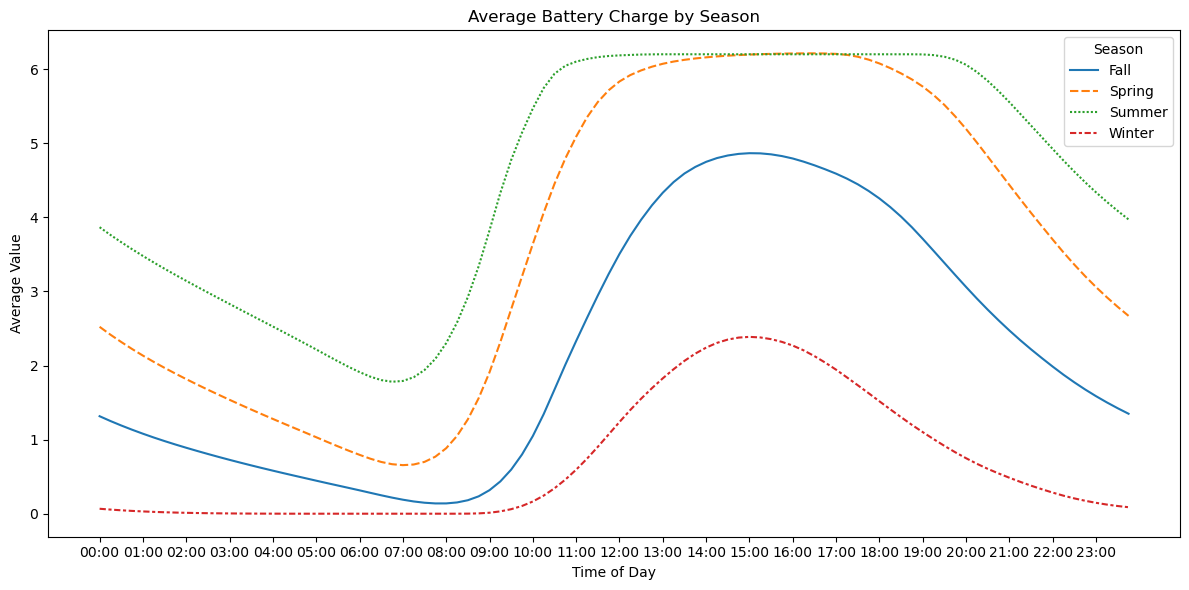

In [8]:
# Battery Visualisation

values = np.array(battery.history)  # replace with your data
remainder = len(values) % 96
if remainder != 0:
    pad_len = 96 - remainder
    values = np.append(values, [np.nan] * pad_len)
# Number of days
n_days = len(values) // 96

# Reshape into (96 x n_days)
reshaped = values.reshape(n_days, 96).T   # transpose to get 96 rows

# Create time slot index
time_slots = pd.date_range("00:00", "23:45", freq="15min").strftime("%H:%M")

# Create column labels (Day1, Day2, ...)
day_labels = pd.date_range("2024-01-01", periods=n_days, freq="D").date

# Build DataFrame
df = pd.DataFrame(reshaped, index=time_slots, columns=day_labels)

df.columns = pd.to_datetime(df.columns)

# Step 2: Group by month and take the mean across days
monthly_avg = df.groupby(df.columns.to_series().dt.month, axis=1).mean()

# Step 3: Define month-to-season mapping
season_map = {
    12: "Winter", 1: "Winter", 2: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Fall", 10: "Fall", 11: "Fall"
}

# Step 4: Collapse into 4 season columns
seasonal_avg = monthly_avg.groupby(monthly_avg.columns.map(season_map), axis=1).mean()

# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=seasonal_avg)

plt.title("Average Battery Charge by Season")
plt.xlabel("Time of Day")
plt.ylabel("Average Value")
plt.legend(title="Season")

# show only every 4th tick (i.e. every hour)
tick_positions = np.arange(0, len(seasonal_avg.index), 4)
plt.xticks(tick_positions, seasonal_avg.index[tick_positions])

plt.tight_layout()
plt.show()